In [1]:
import os
import torch
import nglview
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from torch_geometric.data import Data, Batch 

import nglview
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw


from ase.visualize import view
from ase import Atoms

IPythonConsole.ipython_useSVG = True 
IPythonConsole.molSize = 300, 300
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib notebook

In [2]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets
from ipywidgets import interact, interactive, fixed, IntSlider

In [3]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [4]:
def repeat_data(data: Data, num_repeat) -> Batch:
    datas = [deepcopy(data) for i in range(num_repeat)]
    return Batch.from_data_list(datas)


def repeat_batch(batch: Batch, num_repeat) -> Batch:
    datas = batch.to_data_list()
    new_data = []
    for i in range(num_repeat):
        new_data += deepcopy(datas)
    return Batch.from_data_list(new_data)

In [5]:
from e3moldiffusion import chem
from geom.data import GeomDataModule, MolFeaturization
from geom.train import Trainer

In [6]:
def compute_distances(pos):
    d = torch.cdist(pos, pos)
    ids = torch.triu_indices(pos.size(0), pos.size(0), 1)
    d = torch.triu(d, diagonal=1)
    d = d[ids[0, :], ids[1, :]]
    return d

In [7]:
!nvidia-smi

Sun Feb 19 07:48:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   42C    P0    44W / 300W |      0MiB / 32510MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!echo "checking if the compute node has access to the hpfs directory where data is stored."
!ls /hpfs/

checking if the compute node has access to the hpfs directory where data is stored.
apps  gpfs  hpcarchive	projects  scratch  testfs  userws


In [9]:
device = "cuda:0"
# device = "cpu"

In [10]:
datamodule = GeomDataModule(
        batch_size=1,
        num_workers=1,
        dataset="drugs",
        env_in_init=True,
        shuffle_train=True,
        transform=MolFeaturization(order=3),
        max_num_conformers=30
    )
datamodule.setup()

In [11]:
print(f"Training set. Number of structures: {len(datamodule.train_dataset)}")
print(f"Validation set. Number of structures: {len(datamodule.val_dataset)}")
print(f"Test set. Number of structures: {len(datamodule.test_dataset)}")

Training set. Number of structures: 6512131
Validation set. Number of structures: 641189
Test set. Number of structures: 103753


In [12]:
model = Trainer.load_from_checkpoint('logs/drugs/run6/last.ckpt', strict=False).to(device)
model = model.eval()

In [13]:
loader = iter(datamodule.val_dataloader(shuffle=True))

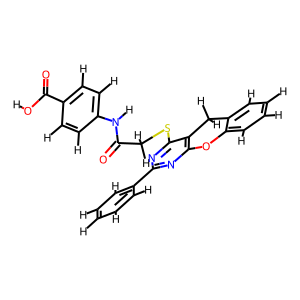

In [14]:
data = next(loader).to(device)
mol = data.mol[0]
mol

In [15]:
steps = 1000
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=data.x,
                                       batch=data.batch,
                                       bond_edge_index=data.edge_index,
                                       bond_edge_attr=data.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 1000)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.15it/s]


In [16]:
print(pos.isnan().sum())
print(pos.max(), pos.min())

tensor(0, device='cuda:0')
tensor(17.0164, device='cuda:0') tensor(-8.4621, device='cuda:0')


In [17]:
original_mol = deepcopy(mol)
copied_mol = deepcopy(mol)

In [18]:
# nglview.show_rdkit(original_mol)
viewer = MolTo3DView(original_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
pos = pos_sde_traj[-1]
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos.detach().cpu().numpy())
# nglview.show_rdkit(copied_mol)
viewer = MolTo3DView(copied_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
mol_trajs = [None for i in range(len(pos_sde_traj))]
for i, p in enumerate(pos_sde_traj):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [21]:
def conf_viewer(idx):
    mol = mol_trajs[idx]
    return MolTo3DView(mol).show()

In [22]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=5))

interactive(children=(IntSlider(value=0, description='idx', max=999, step=5), Output()), _dom_classes=('widget…

<function __main__.conf_viewer(idx)>

In [23]:
nrepeats = 100
batch = repeat_data(data, num_repeat=nrepeats)

In [24]:
batch

DataBatch(x=[5300, 1], edge_index=[2, 11400], edge_attr=[11400], pos=[5300, 3], mol=[100], smiles=[100], edge_index_fc=[2, 275600], energy=[100, 1], boltzmannweight=[100, 1], batch=[5300])

In [25]:
steps = 1000
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=batch.x,
                                       batch=batch.batch,
                                       bond_edge_index=batch.edge_index,
                                       bond_edge_attr=batch.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=False)
pos_sde_traj, pos_mean_traj = traj

range(0, 1000)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.75it/s]


In [26]:
pos = torch.stack(pos.chunk(nrepeats, dim=0))
pos = pos.cpu()

In [27]:
original_mol = deepcopy(mol)
nglview.show_rdkit(original_mol)

NGLWidget()

In [28]:
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos[0])
nglview.show_rdkit(copied_mol)

NGLWidget()

In [29]:
mol_trajs = [None for i in range(len(pos))]
for i, p in enumerate(pos):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [30]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>